In [1]:
import mne
from mne.io import concatenate_raws, read_raw_edf
import matplotlib.pyplot as plt
import mne.viz
import os
import os.path as op
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test
from mne.datasets import fetch_fsaverage

import torch
from torcheeg.models import EEGNet
from torcheeg.models import DGCNN
from torcheeg import transforms

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy as sc
from matplotlib import cm
import matplotlib.colors as colors

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 


/home/aurelien.stumpf/Development/BCI_Classification/eeg_env/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [2]:
import sys 
sys.path.append("/home/aurelien.stumpf/Development/BCI_Classification/")
from eeg_project_package import dataset, models, spectral_analysis, training

In [75]:
import importlib
importlib.reload(dataset)
importlib.reload(training)
importlib.reload(models)
importlib.reload(spectral_analysis)

<module 'eeg_project_package.spectral_analysis' from '/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/spectral_analysis.py'>

## Check Loading of Physio Dataset Files

Number of channels:  64
Number of samples:  64


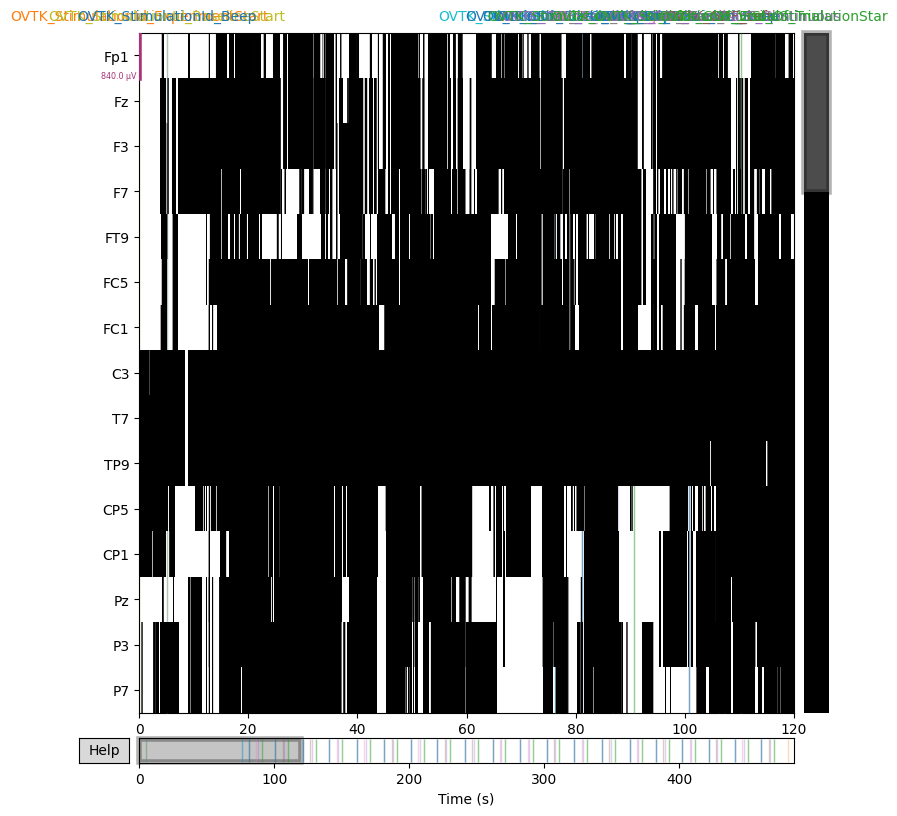

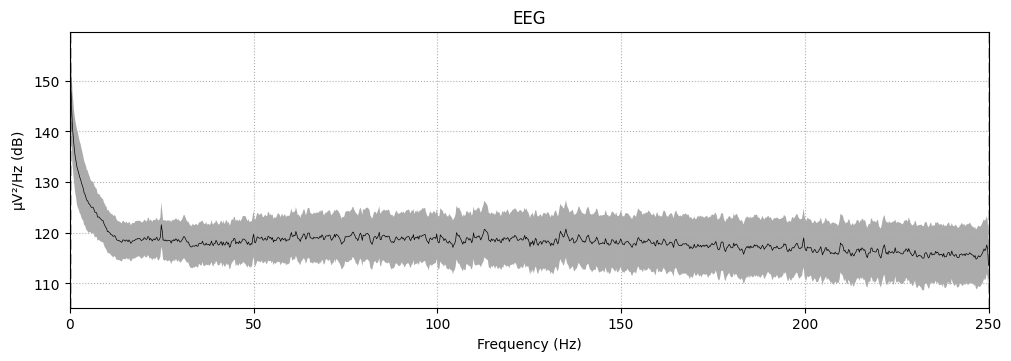

In [3]:
#Define the parameters
subject = 1  # use data from subject 1
runs = [6, 10, 14]  # use only hand and feet motor imagery runs

#Get data and locate in to given path
input_fname1 =  "/network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-01/EEG/Test-[2022.03.28-17.46.29].edf"
#Read raw data files where each file contains a run
raws = read_raw_edf(input_fname1, preload=True)
#Combine all loaded runs
#raw_obj = concatenate_raws(raws)
raw_obj = raws

raw_data = raw_obj.get_data()
print("Number of channels: ", str(len(raw_data)))
print("Number of samples: ", str(len(raw_data)))

#Plot epochs & PSD
raw_obj.plot(duration=120, n_channels=15, scalings=dict(eeg=420e-6))
raw_obj.plot_psd(average=True)

# list of all channel names
list_all_ch_names = raw_obj.ch_names

In [4]:
dict_channels = {'Fc5.' : 'FC5',
 'Fc3.' : 'FC3',
 'Fc1.' : 'FC1',
 'Fcz.' : 'FCz',
 'Fc2.' : 'FC2',
 'Fc4.' : 'FC4',
 'Fc6.' : 'FC6',
 'C5..' : 'C5',
 'C3..' : 'C3',
 'C1..' : 'C1',
 'Cz..' : 'Cz',
 'C2..' : 'C2',
 'C4..' : 'C4',
 'C6..' : 'C6',
 'Cp5.' : 'CP5',
 'Cp3.' : 'CP3',
 'Cp1.' : 'CP1',
 'Cpz.' : 'CPz',
 'Cp2.' : 'CP2',
 'Cp4.' : 'CP4',
 'Cp6.' : 'CP6',
 'Fp1.' : 'Fp1',
 'Fpz.' : 'Fpz',
 'Fp2.' : 'Fp2',
 'Af7.' : 'AF7',
 'Af3.' : 'AF3',
 'Afz.' : 'AFz',
 'Af4.' : 'AF4',
 'Af8.' : 'AF8',
 'F7..' : 'F7',
 'F5..' : 'F5',
 'F3..' : 'F3',
 'F1..' : 'F1',
 'Fz..' : 'Fz',
 'F2..' : 'F2',
 'F4..' : 'F4',
 'F6..' : 'F6',
 'F8..' : 'F8',
 'Ft7.' : 'FT7',
 'Ft8.' : 'FT8',
 'T7..' : 'T7',
 'T8..' : 'T8',
 'T9..' : 'T9',
 'T10.' : 'T10',
 'Tp7.' : 'TP7',
 'Tp8.' : 'TP8',
 'P7..' : 'P7',
 'P5..' : 'P5',
 'P3..' : 'P3',
 'P1..' : 'P1',
 'Pz..' : 'Pz',
 'P2..' : 'P2',
 'P4..' : 'P4',
 'P6..' : 'P6',
 'P8..' : 'P8',
 'Po7.' : 'PO7',
 'Po3.' : 'PO3',
 'Poz.' : 'POz',
 'Po4.' : 'PO4',
 'Po8.' : 'PO8',
 'O1..' : 'O1',
 'Oz..' : 'Oz',
 'O2..' : 'O2',
 'Iz..' : 'Iz'}

# Make ordered dict of channels
dict_channels_ordered = dict(sorted(dict_channels.items()))


## One-Subject Classif

/network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-03/EEG/Test-[2022.04.11-17.11.28].edf


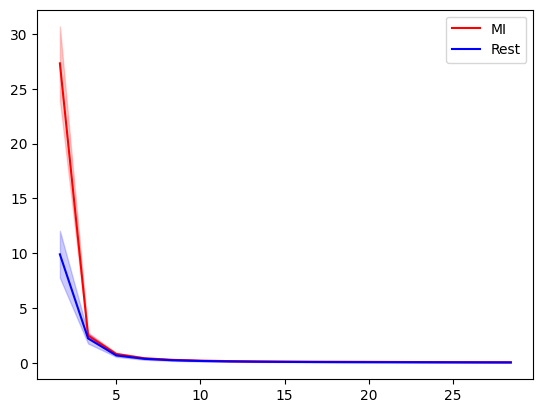

/network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-03/EEG/Test-[2022.04.11-17.22.38].edf


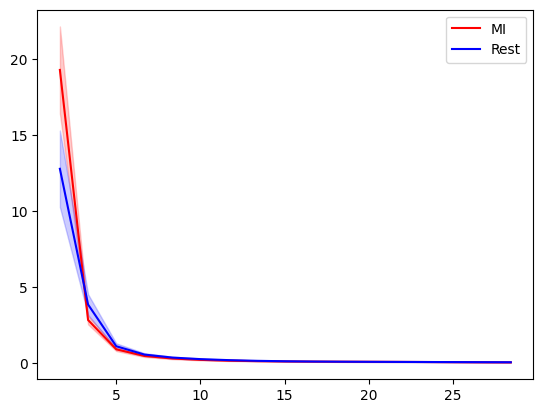

/network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-03/EEG/Test-[2022.04.11-16.35.28].edf


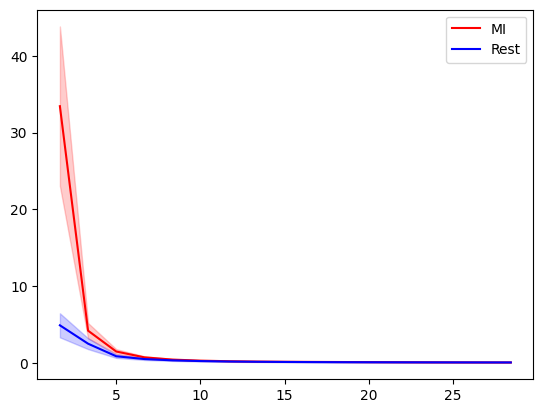

/network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-03/EEG/Train-[2022.04.11-15.58.09].edf


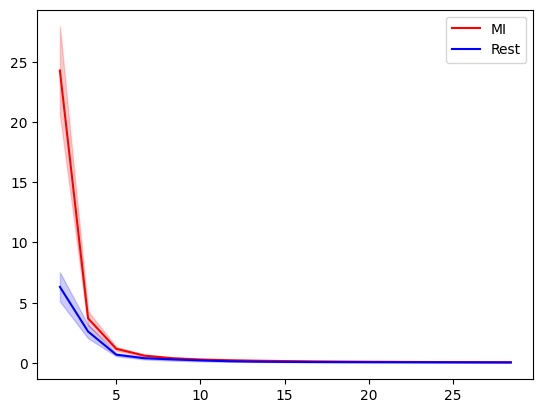

/network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-03/EEG/Test-[2022.04.11-16.44.17].edf


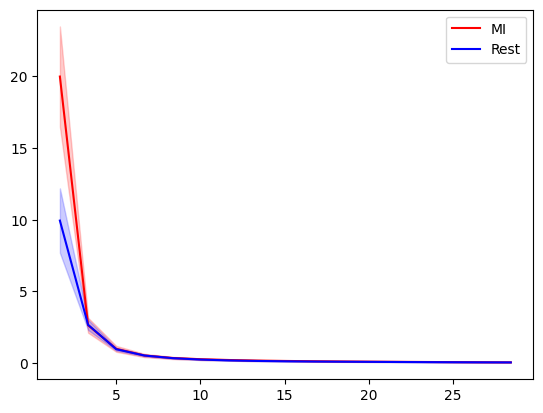

/network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-03/EEG/Train-[2022.04.11-16.16.13].edf


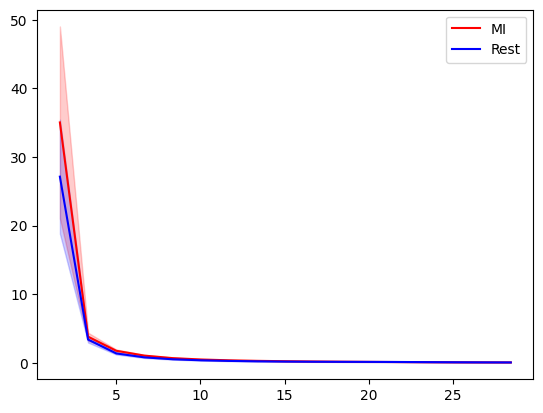

/network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-03/EEG/Test-[2022.04.11-16.52.39].edf


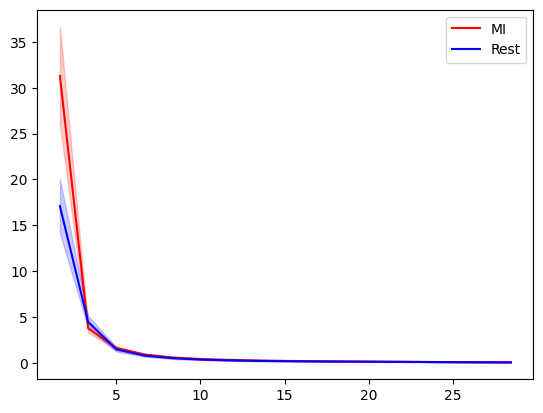

In [71]:
folder_path = "/network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-03/EEG/"
files = [folder_path + f for f in os.listdir(folder_path) if f.endswith('.edf') and not(f.startswith("._"))]

labels = ['OVTK_GDF_Left', 'OVTK_GDF_Right']
#list_name_channels = ["CP1","CP3","CP5","C1","C3"]
list_name_channels = ["CP1","CP3","CP5","C1","C3","C5","C2","CP2","Cz","FCz","C4","CP4"]
ch_names = raw_obj.info['ch_names']
list_idx_channels = [ch_names.index(name) for name in list_name_channels]

for file in files :
    print(file)
    list_file = [file]
    try : 
        signal, list_labels, list_freqs = dataset.psd_dataset_creator(list_file, list_idx_channels, labels, type_psd = "burg")
        colors = ['r','b']
        idx_freqs = np.argwhere((list_freqs >= 1) & (list_freqs <= 30)).reshape(-1)
        # Plot the PSD with variance
        if signal.shape[0] == 0:
            continue
        else:
            label_rest = np.argwhere(list_labels == 0)
            signal = np.sum(signal, axis = 1)
            signal_rest = np.mean(signal[label_rest,:],axis = 0).reshape(-1)
            signal_rest_std_dev = np.std(signal[label_rest,:],axis = 0).reshape(-1) / np.sqrt(len(label_rest))
            plt.plot(list_freqs[idx_freqs],signal_rest[idx_freqs], color='r', label = "MI")
            plt.fill_between(list_freqs[idx_freqs], signal_rest[idx_freqs]-signal_rest_std_dev[idx_freqs], signal_rest[idx_freqs]+signal_rest_std_dev[idx_freqs], color='r', alpha=0.2)

            label_mi = np.argwhere(list_labels == 1)
            signal_mi = np.mean(signal[label_mi,:],axis = 0).reshape(-1)
            signal_mi_std_dev = np.std(signal[label_mi,:],axis = 0).reshape(-1) / np.sqrt(len(label_mi))
            plt.plot(list_freqs[idx_freqs],signal_mi[idx_freqs], color='b', label = "Rest")
            plt.fill_between(list_freqs[idx_freqs], signal_mi[idx_freqs]-signal_mi_std_dev[idx_freqs], signal_mi[idx_freqs]+signal_mi_std_dev[idx_freqs], color='b', alpha=0.2)

            plt.legend()

            plt.show()
    except Exception as e:
        print(e)
        continue

Subject:  03  Session:  02
Train files:  ['/network/lustre/iss02/aramis/projects/cracknetworks/sub-03/ses-02/EEG/Test-[2022.03.22-16.56.44].edf', '/network/lustre/iss02/aramis/projects/cracknetworks/sub-03/ses-02/EEG/Test-[2022.03.22-16.40.09].edf', '/network/lustre/iss02/aramis/projects/cracknetworks/sub-03/ses-02/EEG/Train-[2022.03.22-15.49.46].edf', '/network/lustre/iss02/aramis/projects/cracknetworks/sub-03/ses-02/EEG/Train-[2022.03.22-15.39.56].edf', '/network/lustre/iss02/aramis/projects/cracknetworks/sub-03/ses-02/EEG/Train-[2022.03.22-15.30.18].edf', '/network/lustre/iss02/aramis/projects/cracknetworks/sub-03/ses-02/EEG/Train-[2022.03.22-15.58.38].edf', '/network/lustre/iss02/aramis/projects/cracknetworks/sub-03/ses-02/EEG/Test-[2022.03.22-16.48.37].edf']
/network/lustre/iss02/aramis/projects/cracknetworks/sub-03/ses-02/EEG/Test-[2022.03.22-16.56.44].edf


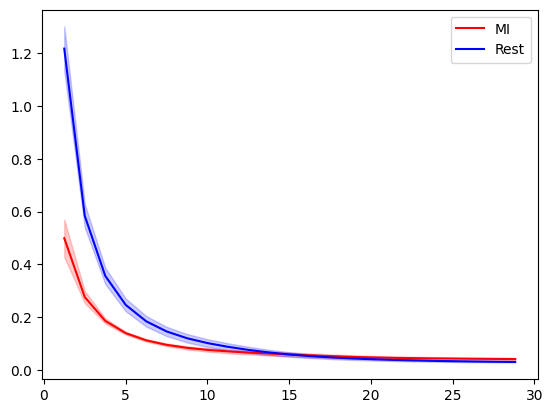

/network/lustre/iss02/aramis/projects/cracknetworks/sub-03/ses-02/EEG/Test-[2022.03.22-16.40.09].edf


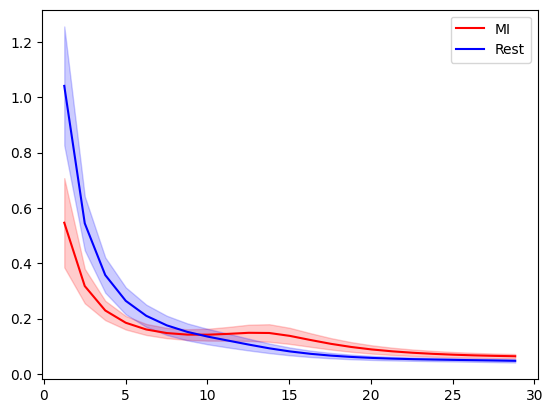

/network/lustre/iss02/aramis/projects/cracknetworks/sub-03/ses-02/EEG/Train-[2022.03.22-15.49.46].edf


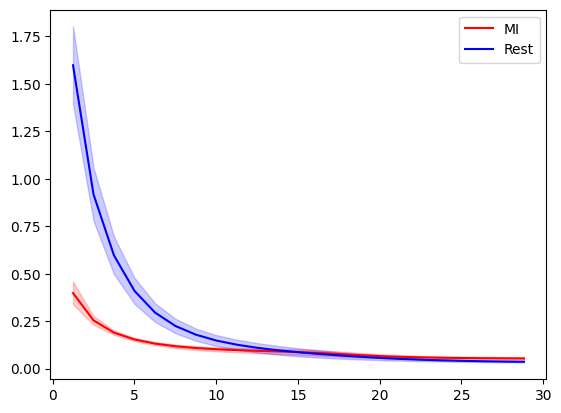

/network/lustre/iss02/aramis/projects/cracknetworks/sub-03/ses-02/EEG/Train-[2022.03.22-15.39.56].edf


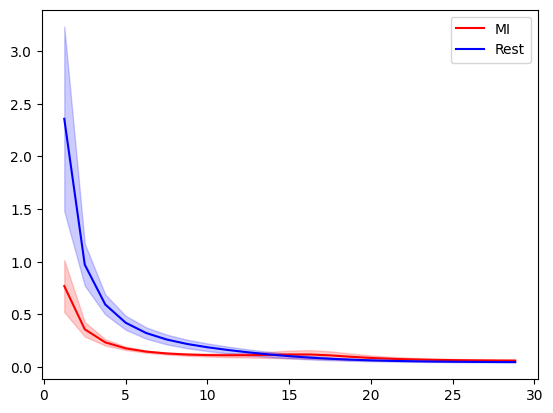

/network/lustre/iss02/aramis/projects/cracknetworks/sub-03/ses-02/EEG/Train-[2022.03.22-15.30.18].edf


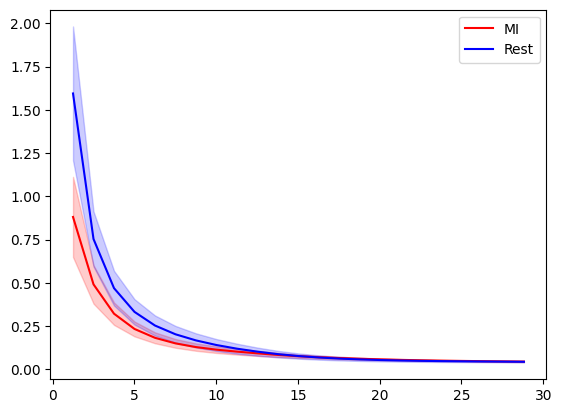

/network/lustre/iss02/aramis/projects/cracknetworks/sub-03/ses-02/EEG/Train-[2022.03.22-15.58.38].edf


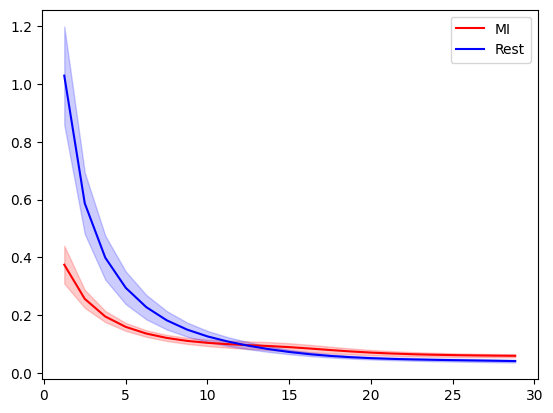

/network/lustre/iss02/aramis/projects/cracknetworks/sub-03/ses-02/EEG/Test-[2022.03.22-16.48.37].edf


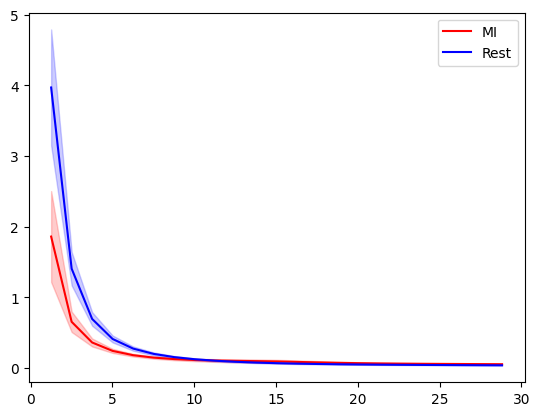

/network/lustre/iss02/aramis/projects/cracknetworks/sub-03/ses-02/EEG/Test-[2022.03.22-16.21.49].edf


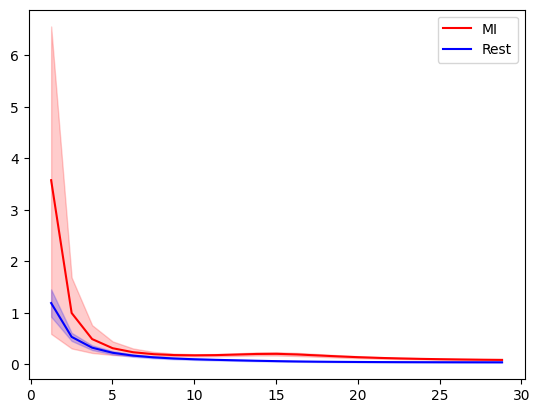

/network/lustre/iss02/aramis/projects/cracknetworks/sub-03/ses-02/EEG/Test-[2022.03.22-16.30.55].edf


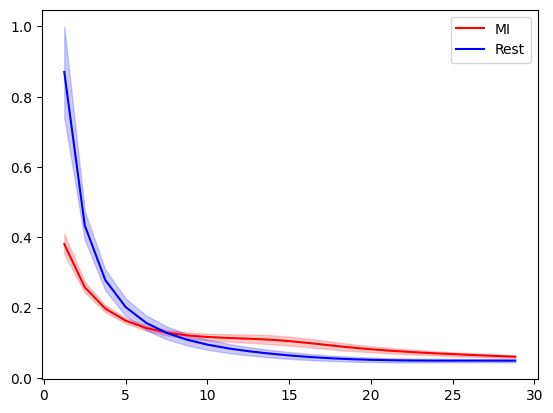

LDA accuracy:  0.75
SVM accuracy:  0.525
rbf SVM accuracy:  0.5


In [98]:
num_subject = 3
num_session = 2

if num_subject < 10:
    subject_number = "0" + str(num_subject)
else:
    subject_number = str(num_subject)

session_number = "0" + str(num_session)

print("Subject: ", subject_number, " Session: ", session_number)

# Define the path to the data
folder_path = "/network/lustre/iss02/aramis/projects/cracknetworks/sub-{}/ses-{}/EEG/".format(subject_number, session_number)

# List all the files in the folder
files = [folder_path + f for f in os.listdir(folder_path) if f.endswith('.edf') and not(f.startswith("._"))]
list_train_files = files[0:-2]
list_test_files = files[-2:]
print("Train files: ", list_train_files)

# Define the channels
list_name_channels = ["CP1","CP3","CP5","C1","C3","C5","C2","CP2","Cz","FCz","C4","CP4"]
list_name_channels = ["CP1","CP3","CP2","CP4","CP6","CPz","C1","C3","C2","C4","C6","Cz","CPz"]
ch_names = raw_obj.info['ch_names']
list_idx_channels = [ch_names.index(name) for name in list_name_channels]

dict_ = {"type_psd":"burg","tmin":0,"tmax":4,"fs":500,"nfft":400,"noverlap":100,"nperseg":400,"filter_order":19,"fmin":4,"fmax":30}

for file in files :
    print(file)
    list_file = [file]
    try : 
        signal, list_labels, list_freqs = dataset.psd_dataset_creator(list_file, list_idx_channels, labels, type_psd = dict_["type_psd"], tmin = dict_["tmin"], tmax = dict_["tmax"], fs = dict_["fs"], nfft = dict_["nfft"], noverlap = dict_["noverlap"], nperseg = dict_["nperseg"], filter_order = dict_["filter_order"], fmin = dict_["fmin"], fmax = dict_["fmax"])
        colors = ['r','b']
        idx_freqs = np.argwhere((list_freqs >= 1) & (list_freqs <= 30)).reshape(-1)
        # Plot the PSD with variance
        if signal.shape[0] == 0:
            continue
        else:
            label_rest = np.argwhere(list_labels == 0)
            signal = np.sum(signal, axis = 1)
            signal_rest = np.mean(signal[label_rest,:],axis = 0).reshape(-1)
            signal_rest_std_dev = np.std(signal[label_rest,:],axis = 0).reshape(-1) / np.sqrt(len(label_rest))
            plt.plot(list_freqs[idx_freqs],signal_rest[idx_freqs], color='r', label = "MI")
            plt.fill_between(list_freqs[idx_freqs], signal_rest[idx_freqs]-signal_rest_std_dev[idx_freqs], signal_rest[idx_freqs]+signal_rest_std_dev[idx_freqs], color='r', alpha=0.2)

            label_mi = np.argwhere(list_labels == 1)
            signal_mi = np.mean(signal[label_mi,:],axis = 0).reshape(-1)
            signal_mi_std_dev = np.std(signal[label_mi,:],axis = 0).reshape(-1) / np.sqrt(len(label_mi))
            plt.plot(list_freqs[idx_freqs],signal_mi[idx_freqs], color='b', label = "Rest")
            plt.fill_between(list_freqs[idx_freqs], signal_mi[idx_freqs]-signal_mi_std_dev[idx_freqs], signal_mi[idx_freqs]+signal_mi_std_dev[idx_freqs], color='b', alpha=0.2)

            plt.legend()
            plt.show()
    except Exception as e:
        print(e)
        continue

# Define the labels
list_labels = ['OVTK_GDF_Left', 'OVTK_GDF_Right']

trainset = dataset.EEG_Dataset(files_list = list_train_files, list_idx_channels = list_idx_channels, list_labels = list_labels, feature_type = "psd", dict_ = dict_)
testset = dataset.EEG_Dataset(files_list = list_test_files, list_idx_channels = list_idx_channels, list_labels = list_labels, feature_type = "psd", dict_ = dict_)

X_train = trainset.features[:,:,:].reshape(trainset.features.shape[0], -1)
y_train = trainset.labels
X_test = testset.features[:,:,:].reshape(testset.features.shape[0], -1)
y_test = testset.labels

# Train LDA classifier
lda_clf = LinearDiscriminantAnalysis()
lda_clf.fit(X_train, y_train)
y_pred = lda_clf.predict(X_test)
acc = np.mean(y_pred == y_test)
print("LDA accuracy: ", acc)

# Train SVM classifier
svm_clf = SVC(kernel='linear')
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)
acc = np.mean(y_pred == y_test)
print("SVM accuracy: ", acc)

# Train SVM classifier
svm_clf = SVC(kernel='rbf')
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)
acc = np.mean(y_pred == y_test)
print("rbf SVM accuracy: ", acc)

In [80]:
lda_accuracies = []
linear_svm_accuracies = []
rbf_svm_accuracies = []

for num_subject in [1,2,3,5,6,7,8,10,11,13,14]:

    for num_session in [1,2,3]:

        if num_subject < 10:
            subject_number = "0" + str(num_subject)
        else:
            subject_number = str(num_subject)

        session_number = "0" + str(num_session)

        print("Subject: ", subject_number, " Session: ", session_number)

        # Define the path to the data
        folder_path = "/network/lustre/iss02/aramis/projects/cracknetworks/sub-{}/ses-{}/EEG/".format(subject_number, session_number)

        # List all the files in the folder
        files = [folder_path + f for f in os.listdir(folder_path) if f.endswith('.edf') and not(f.startswith("._"))]
        list_train_files = files[0:-2]
        list_test_files = files[-2:]
        print("Train files: ", list_train_files)

        # Define the labels
        list_labels = ['OVTK_GDF_Left', 'OVTK_GDF_Right']

        # Define the channels
        list_name_channels = ["CP1","CP3","CP5","C1","C3","C5","C2","CP2","Cz","FCz","C4","CP4"]
        ch_names = raw_obj.info['ch_names']
        list_idx_channels = [ch_names.index(name) for name in list_name_channels]

        dict_ = {"type_psd":"burg","tmin":0,"tmax":4,"fs":500,"nfft":300,"noverlap":150,"nperseg":300,"filter_order":19,"fmin":4,"fmax":30}
        trainset = dataset.EEG_Dataset(files_list = list_train_files, list_idx_channels = list_idx_channels, list_labels = list_labels, feature_type = "psd", dict_ = dict_)
        testset = dataset.EEG_Dataset(files_list = list_test_files, list_idx_channels = list_idx_channels, list_labels = list_labels, feature_type = "psd", dict_ = dict_)

        X_train = trainset.features[:,:,:].reshape(trainset.features.shape[0], -1)
        y_train = trainset.labels
        X_test = testset.features[:,:,:].reshape(testset.features.shape[0], -1)
        y_test = testset.labels

        # Train LDA classifier
        lda_clf = LinearDiscriminantAnalysis()
        lda_clf.fit(X_train, y_train)
        y_pred = lda_clf.predict(X_test)
        acc = np.mean(y_pred == y_test)
        print("LDA accuracy: ", acc)
        lda_accuracies.append(acc)

        # Train Linear SVM classifier
        svm_clf = SVC(kernel='linear')
        svm_clf.fit(X_train, y_train)
        y_pred = svm_clf.predict(X_test)
        acc = np.mean(y_pred == y_test)
        print("Linear SVM accuracy: ", acc)
        linear_svm_accuracies.append(acc)

        # Train Gaussian SVM classifier
        svm_clf = SVC(kernel='rbf')
        svm_clf.fit(X_train, y_train)
        y_pred = svm_clf.predict(X_test)
        acc = np.mean(y_pred == y_test)
        print("Gaussian SVM accuracy: ", acc)
        rbf_svm_accuracies.append(acc)

Subject:  01  Session:  01
Train files:  ['/network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-01/EEG/Train-[2022.03.28-17.08.38].edf', '/network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-01/EEG/Train-[2022.03.28-16.58.43].edf', '/network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-01/EEG/Test-[2022.03.28-18.23.31].edf', '/network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-01/EEG/Test-[2022.03.28-17.36.22].edf', '/network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-01/EEG/Test-[2022.03.28-18.14.13].edf', '/network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-01/EEG/Test-[2022.03.28-17.56.08].edf']
LDA accuracy:  0.725
Linear SVM accuracy:  0.8
Gaussian SVM accuracy:  0.75
Subject:  01  Session:  02
Train files:  ['/network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-02/EEG/Train-[2022.04.04-16.34.19].edf', '/network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-02/EEG/Train-[2022.04.04-16.15.17].edf', '/ne

KeyboardInterrupt: 

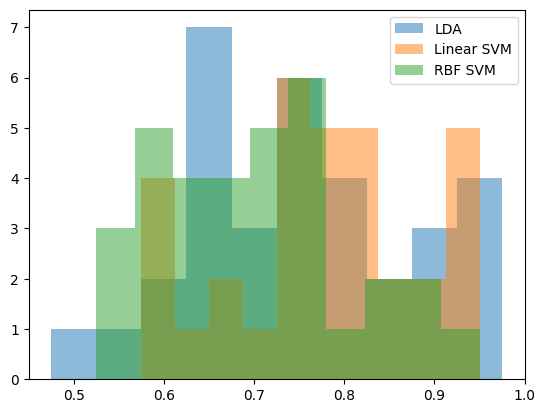

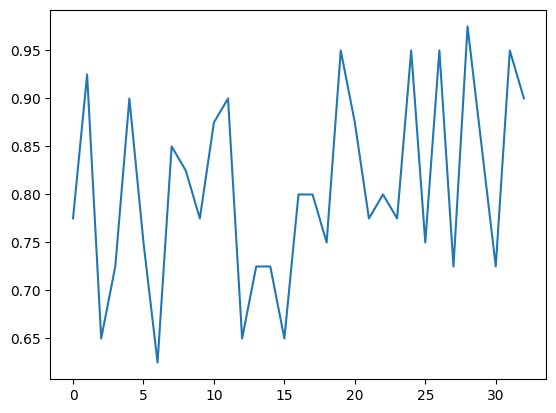

In [70]:
lda_accuracies = np.array(lda_accuracies)
linear_svm_accuracies = np.array(linear_svm_accuracies)
rbf_svm_accuracies = np.array(rbf_svm_accuracies)

plt.hist(lda_accuracies, bins=10, alpha=0.5, label="LDA")
plt.hist(linear_svm_accuracies, bins=10, alpha=0.5, label="Linear SVM")
plt.hist(rbf_svm_accuracies, bins=10, alpha=0.5, label="RBF SVM")
plt.legend()
plt.show()

li_accuracies = np.concatenate([lda_accuracies.reshape(-1,1), linear_svm_accuracies.reshape(-1,1), rbf_svm_accuracies.reshape(-1,1)], axis=1)
plt.plot(np.max(li_accuracies,axis=1), '-')
plt.show()